# Método de Holt-Winters multiplicativo

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [2]:
# importamos los datos en un dataframe
dataframe=pd.read_csv("dataframe_HW.csv",header=0)

In [3]:
#definimos una función que formatea nuestro df
def prepararDf(dataframe):
    df=dataframe.copy()
    df.index+=1
    df.columns = ['periodo','Y(t)']
    df['t'] = df.index
    return df

df=prepararDf(dataframe)
df.head()

,periodo,Y(t),t
1,ene-81,23.105,1
2,feb-81,23.110,2
3,mar-81,21.759,3
4,abr-81,22.073,4
5,may-81,21.937,5


# Método

In [4]:
#Función del formato de tabla del método
def calcularValoresHoltWintersMultiplicativo(dataframe,periodo,alfa=0.5,beta=0.3,gama=0.2):
    df = dataframe.copy()
    L=periodo

    # Preparación de columnas
    df['A(t)'] = np.NaN
    df['T(t)'] = np.NaN
    df['S(t)'] = np.NaN

    # Estadisticos de linea de tendencia
    X=df['t']
    Y=df['Y(t)']
    X = sm.add_constant(X)
    modelo = sm.OLS(Y,X)
    resultado = modelo.fit()

    A0=resultado.params['const']
    Tt=resultado.params['t']
    # Datos iniciales en renglon 0
    df.loc[0]=[np.NaN,np.NaN,0,A0,Tt,np.NaN]

    #Valores de S(t)
    for t in range((L*-1)+1,1):
        Yt=df.loc[t+L,'Y(t)']
        St=Yt/A0

        df.loc[t,'S(t)']=St
        df.loc[t,'t']=t
    # Ordenamos el dataframe para que los datos negativos
    # queden en la cabecera del dataframe
    df=df.sort_index(ascending=True)
 

    
    inicio = 1
    final= df.shape[0]-L+1
    # Cálcular valores desde renglon 1 hasta renglon final(n-L) 
    for t in range(inicio, final,1):
        Yt = df.loc[t, 'Y(t)']
        St_L = df.loc[t-L, 'S(t)']

        # cálculo A(t)
        At_1 = df.loc[t-1, 'A(t)']
        Tt_1 = df.loc[t-1, 'T(t)']
        At = alfa*(Yt/St_L) + (1-alfa)*(At_1+Tt_1)
        df.loc[t, 'A(t)'] = At

        # cálculo T(t)
        Tt = beta*(At - At_1) + (1 - beta)*Tt_1
        df.loc[t, "T(t)"] = Tt

        # cálculo S(t)
        St = gama*(Yt/At) + (1-gama)*St_L
        df.loc[t, 'S(t)'] = St

    ''''''
    #print(df.loc[1-L, 'S(t)'])
    return df

df2=calcularValoresHoltWintersMultiplicativo(df,12)
df2.head(14)

,periodo,Y(t),t,A(t),T(t),S(t)
-11,NaN,NaN,-11.0,NaN,NaN,1.067775
-10,NaN,NaN,-10.0,NaN,NaN,1.068006
-9,NaN,NaN,-9.0,NaN,NaN,1.005571
-8,NaN,NaN,-8.0,NaN,NaN,1.020082
-7,NaN,NaN,-7.0,NaN,NaN,1.013797
-6,NaN,NaN,-6.0,NaN,NaN,0.925898
-5,NaN,NaN,-5.0,NaN,NaN,1.090189
-4,NaN,NaN,-4.0,NaN,NaN,1.001550
-3,NaN,NaN,-3.0,NaN,NaN,1.026968
-2,NaN,NaN,-2.0,NaN,NaN,1.022393


In [5]:
#Funcion de pronostico
def pronosticoHoltWintersMultiplicativo(dataframe,periodo):
    df = dataframe.copy()
    df['p'] = np.NaN
    df['F(t+p)'] = np.NaN
    L=periodo

    final = df.shape[0]-L
    #df.loc[1:final,'p'] = 1 # inicia p en 1
    # ciclo de pronostico para los renglones con valor en Y(t) 
    for t in range(1,final+1): 
        At = df.loc[t, 'A(t)']
        p = 1 
        df.loc[t, 'p']=1
        Tt = df.loc[t,'T(t)']
        St_Lp = df.loc[t-L+p,'S(t)'] 

        Ftp = (At + p*Tt)*St_Lp

        df.loc[t+p, 'F(t+p)'] = Ftp
    
    #Inicio de ciclo para pronosticar tiempos adelante
    At = df.loc[t, 'A(t)']
    Tt = df.loc[t,'T(t)']
    St_Lp = df.loc[t-L+p,'S(t)']

    #print(t)
    for t in range(final+1, final+L-1):
        p = df.loc[t-1,'p'] + 1
        df.loc[t,'p'] = p
        St_Lp = df.loc[t-L+1,'S(t)']
        Ftp = (At + p*Tt)*St_Lp

        df.loc[t+1, 'F(t+p)'] = Ftp        

        
    return df

df3=pronosticoHoltWintersMultiplicativo(df2,12)
df3.tail(20)

,periodo,Y(t),t,A(t),T(t),S(t),p,F(t+p)
100,abr-89,26.881,100.0,26.307630,0.116829,1.024066,1.0,27.030345
101,may-89,26.217,101.0,26.110098,0.022521,1.013883,1.0,26.855989
102,jun-89,24.218,102.0,25.859339,-0.059463,0.944531,1.0,24.735338
103,jul-89,27.914,103.0,25.846418,-0.045500,1.078442,1.0,27.813651
104,ago-89,26.975,104.0,26.376204,0.127086,1.005238,1.0,25.823422
105,sep-89,28.527,105.0,26.975084,0.268624,1.042989,1.0,27.546278
106,oct-89,27.139,106.0,26.771406,0.126933,1.028295,1.0,28.113772
107,nov-89,28.982,107.0,26.638382,0.048946,1.096557,1.0,29.553230
108,dic-89,28.169,108.0,26.342334,-0.054552,1.080696,1.0,28.916626
109,NaN,NaN,NaN,NaN,NaN,NaN,2.0,27.825375


# Errores

In [6]:
def calcularErrores(dataframe):
    df = dataframe.copy()
    df['e(t)'] = np.NaN
    df['|e(t)|'] = np.NaN
    df['e(t)^2'] = np.NaN
    df['|e(t)|/Y(t)'] = np.NaN

    inicio=df['F(t+p)'].first_valid_index()
    final=df['Y(t)'].last_valid_index()+1

    for i in range(inicio,final):
        Yt = df.loc[i]['Y(t)']
        pron = df.loc[i]['F(t+p)']
        et = Yt - pron
        et_abs = np.abs(et)

        df.loc[i, 'e(t)'] = et
        df.loc[i, '|e(t)|'] = et_abs
        df.loc[i, 'e(t)^2'] = et**2
        df.loc[i, '|e(t)|/Y(t)'] = et_abs/Yt

    errores = {
    'DAM': np.mean(df['|e(t)|']),
    'EMC': np.mean(df['e(t)^2']),
    'PEMA': np.mean(df['|e(t)|/Y(t)'])*100,
    }
    df_errores = pd.DataFrame(errores,index=['Errores:'])
    return df,df_errores

df4,df_errores=calcularErrores(df3)
print(df4.tail(12))
print(df_errores.head())

    periodo    Y(t)      t       A(t)      T(t)      S(t)     p     F(t+p)  \
108  dic-89  28.169  108.0  26.342334 -0.054552  1.080696   1.0  28.916626   
109     NaN     NaN    NaN        NaN       NaN       NaN   2.0  27.825375   
110     NaN     NaN    NaN        NaN       NaN       NaN   3.0  27.868359   
111     NaN     NaN    NaN        NaN       NaN       NaN   4.0  25.994372   
112     NaN     NaN    NaN        NaN       NaN       NaN   5.0  26.752819   
113     NaN     NaN    NaN        NaN       NaN       NaN   6.0  26.431509   
114     NaN     NaN    NaN        NaN       NaN       NaN   7.0  24.571983   
115     NaN     NaN    NaN        NaN       NaN       NaN   8.0  27.996860   
116     NaN     NaN    NaN        NaN       NaN       NaN   9.0  26.041619   
117     NaN     NaN    NaN        NaN       NaN       NaN  10.0  26.962686   
118     NaN     NaN    NaN        NaN       NaN       NaN  11.0  26.526741   
119     NaN     NaN    NaN        NaN       NaN       NaN   NaN 

# Gráfica

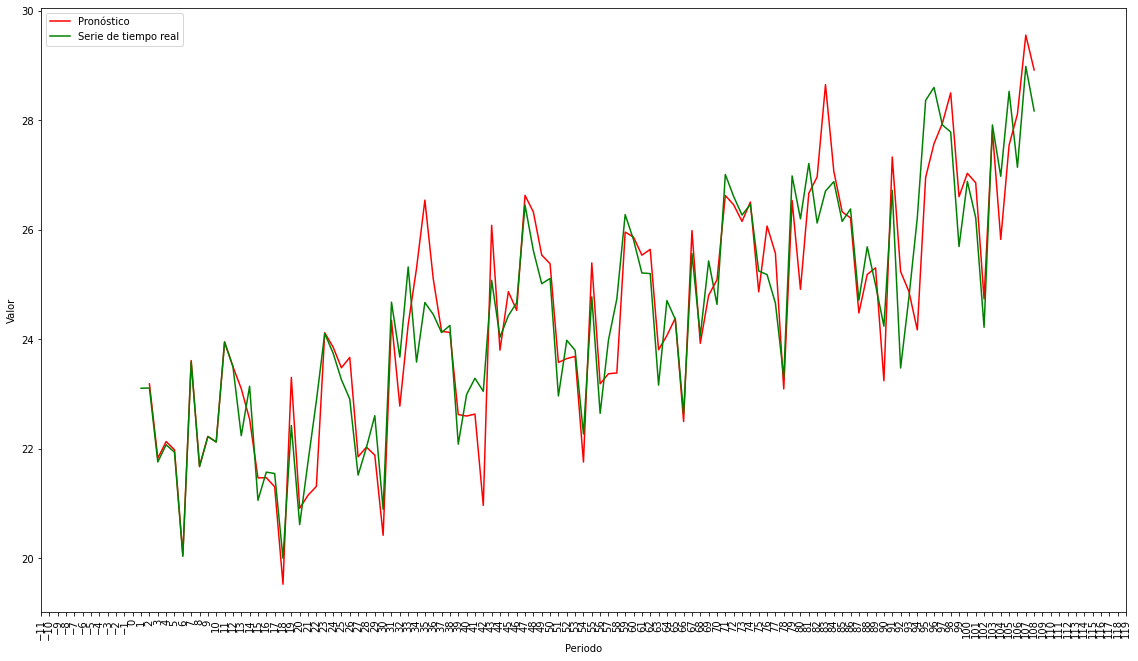

In [7]:
def pintarGrafico(dataframe,ancho=1400,alto=800):
    df=dataframe
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.subplots(figsize=(ancho*px, alto*px))

    # Labels (etiquetas) de ejes x, y
    plt.ylabel('Valor')
    plt.xlabel('Periodo')

    # Puntos, pares ordenados que se calcularon como pronóstico
    plt.plot(
        df['t'], df['F(t+p)'], '-',
        label='Pronóstico',
        color='r'
    )

    # Puntos, pares ordenados que se proporcionaron como datos muestra
    plt.plot(
        df['t'], df['Y(t)'], '-',
        label='Serie de tiempo real',
        color='g'
    )
    
    plt.legend(loc='best')
    plt.xticks(df.index,rotation=90)
    plt.show()

pintarGrafico(df4)

# Pronosticos en las series de tiempo del proyecto:

In [8]:
#Función para ejecutar método en un df completo
def aplicarMetodo(pathArchivocsv,periodo,alfa=0.5,beta=0.3,gama=0.2):
    df=pd.read_csv(pathArchivocsv,header=0)
    df=prepararDf(df)
    df=calcularValoresHoltWintersMultiplicativo(df,periodo,alfa,beta,gama)
    df=pronosticoHoltWintersMultiplicativo(df,periodo)
    df,df_errores=calcularErrores(df)
    return df,df_errores

# Método con mejor PEMA

In [9]:
# Fuerza bruta para aproximar mejor resultado
def aplicarMetodoOptimizado(pathArchivocsv,periodo):
    df=pd.read_csv(pathArchivocsv,header=0)
    df=prepararDf(df)
    PEMAmejor=100.0
    inicio=0.001
    fin=0.9999
    paso=0.2
    for alfa in np.arange(inicio,fin,paso):
        for beta in np.arange(inicio,fin,paso):
            for gama in np.arange(inicio,fin,paso):
                df2=calcularValoresHoltWintersMultiplicativo(df,periodo,alfa,beta,gama)
                df2=pronosticoHoltWintersMultiplicativo(df2,periodo)
                df2,df_errores=calcularErrores(df2)
                PEMA = df_errores.loc['Errores:','PEMA']
                if PEMA<PEMAmejor:
                    dfMejor=df2.copy()
                    df_erroresMejor=df_errores.copy()
                    PEMAmejor=PEMA
                    alfaMejor=alfa
                    betaMejor=beta
                    gamaMejor=gama
    df_erroresMejor['alfa']=[alfaMejor]
    df_erroresMejor['beta']=[betaMejor]
    df_erroresMejor['gama']=[gamaMejor]        
    return dfMejor,df_erroresMejor

    periodo  Y(t)   t  A(t)  T(t)  S(t)     p     F(t+p)  e(t)  |e(t)|  \
115     NaN   NaN NaN   NaN   NaN   NaN   8.0  28.306748   NaN     NaN   
116     NaN   NaN NaN   NaN   NaN   NaN   9.0  26.526179   NaN     NaN   
117     NaN   NaN NaN   NaN   NaN   NaN  10.0  27.729158   NaN     NaN   
118     NaN   NaN NaN   NaN   NaN   NaN  11.0  27.304266   NaN     NaN   
119     NaN   NaN NaN   NaN   NaN   NaN   NaN  29.145488   NaN     NaN   

     e(t)^2  |e(t)|/Y(t)  
115     NaN          NaN  
116     NaN          NaN  
117     NaN          NaN  
118     NaN          NaN  
119     NaN          NaN  
               DAM       EMC      PEMA   alfa   beta   gama
Errores:  0.453915  0.394311  1.849647  0.801  0.001  0.801


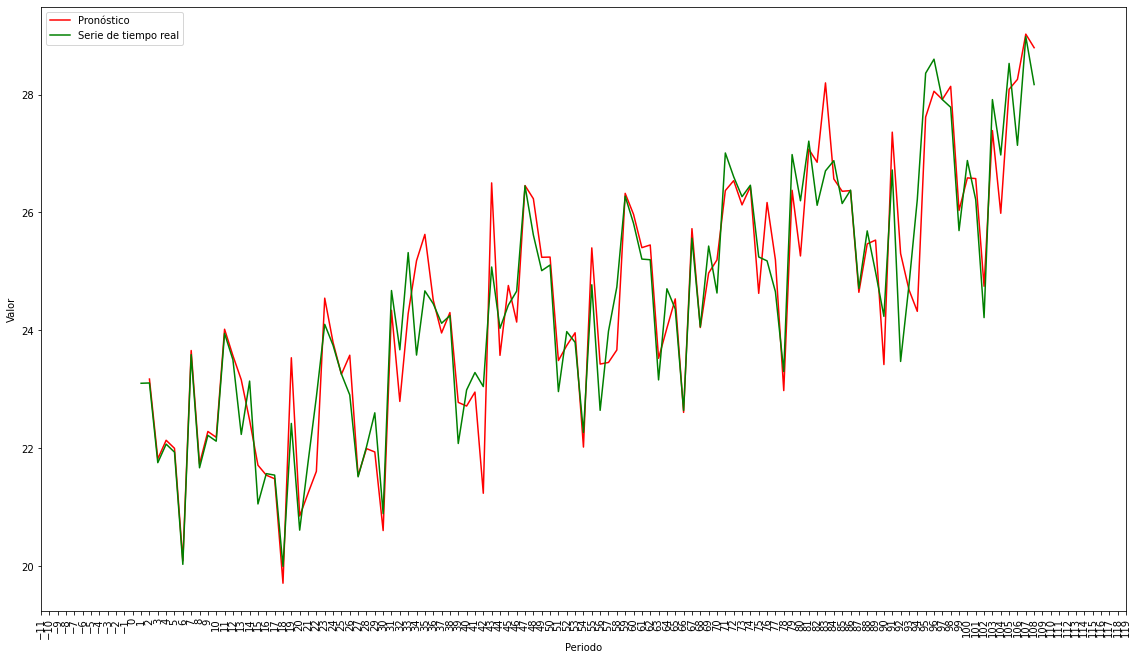

In [10]:
# Serie de ejemplo
dfserie,dfserie_errores = aplicarMetodoOptimizado("dataframe_HW.csv",12)
print(dfserie.tail())
print(dfserie_errores)
pintarGrafico(dfserie)